In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import feature.util as feature_util
import grelu.resources
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import scipy.stats
import sklearn.decomposition
import umap
import geosketch

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.size": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
out_path = "/home/tsenga5/mechint_regnet/results/interpretable_seq_gen_synthesis"

### Import sequences and predictions

In [6]:
seq_table = pd.read_csv(
    os.path.join(out_path, "seq_table.tsv"),
    sep="\t", index_col=False
)

In [7]:
cons_seqs = np.array(seq_table["cons_seq"])
orig_seqs = np.array(seq_table["orig_seq"])
shuf_seqs = np.array(seq_table["shuf_seq"])

cons_one_hots = feature_util.seqs_to_one_hot(cons_seqs)
orig_one_hots = feature_util.seqs_to_one_hot(orig_seqs)
shuf_one_hots = feature_util.seqs_to_one_hot(shuf_seqs)

cons_mechint_preds = np.array(seq_table["cons_mechint_preds"])
cons_mechint_rc_preds = np.array(seq_table["cons_mechint_rc_preds"])
orig_mechint_preds = np.array(seq_table["orig_mechint_preds"])
shuf_mechint_preds = np.array(seq_table["shuf_mechint_preds"])

cons_borzoi_preds = np.array(seq_table["cons_borzoi_preds"])
cons_borzoi_rc_preds = np.array(seq_table["cons_borzoi_rc_preds"])
orig_borzoi_preds = np.array(seq_table["orig_borzoi_preds"])
shuf_borzoi_preds = np.array(seq_table["shuf_borzoi_preds"])

cons_ocb_preds = np.array(seq_table["cons_ocb_preds"])
cons_ocb_rc_preds = np.array(seq_table["cons_ocb_rc_preds"])
orig_ocb_preds = np.array(seq_table["orig_ocb_preds"])
shuf_ocb_preds = np.array(seq_table["shuf_ocb_preds"])

cons_ocz_preds = np.array(seq_table["cons_ocz_preds"])
cons_ocz_rc_preds = np.array(seq_table["cons_ocz_rc_preds"])
orig_ocz_preds = np.array(seq_table["orig_ocz_preds"])
shuf_ocz_preds = np.array(seq_table["shuf_ocz_preds"])

cons_mpra_preds = np.array(seq_table["cons_mpra_preds"])
cons_mpra_rc_preds = np.array(seq_table["cons_mpra_rc_preds"])
orig_mpra_preds = np.array(seq_table["orig_mpra_preds"])
shuf_mpra_preds = np.array(seq_table["shuf_mpra_preds"])

### View agreement between predictions

In [8]:
def plot_correlation_heatmap(data_vecs, labels, ax):
    """
    Plots a labeled correlation heatmap on the given axes. `data_vecs` is a list
    of NumPy arrays containing values (each vector must be the same size).
    `labels` is a parallel list of labels for each one.
    """
    corrs = np.eye(len(data_vecs))
    for i in range(len(data_vecs)):
        for j in range(i):
            corrs[i, j] = scipy.stats.pearsonr(data_vecs[i], data_vecs[j])[0]
        
    ax.imshow(corrs, cmap="Blues")
    for i in range(len(data_vecs)):
        for j in range(i):
            ax.text(j, i, "%.2f" % corrs[i, j], ha="center", va="center")
    
    ax.set_xticks(np.arange(len(data_vecs)))
    ax.set_xticklabels(labels, rotation=-45, ha="left")
    ax.set_yticks(np.arange(len(data_vecs)))
    ax.set_yticklabels(labels)

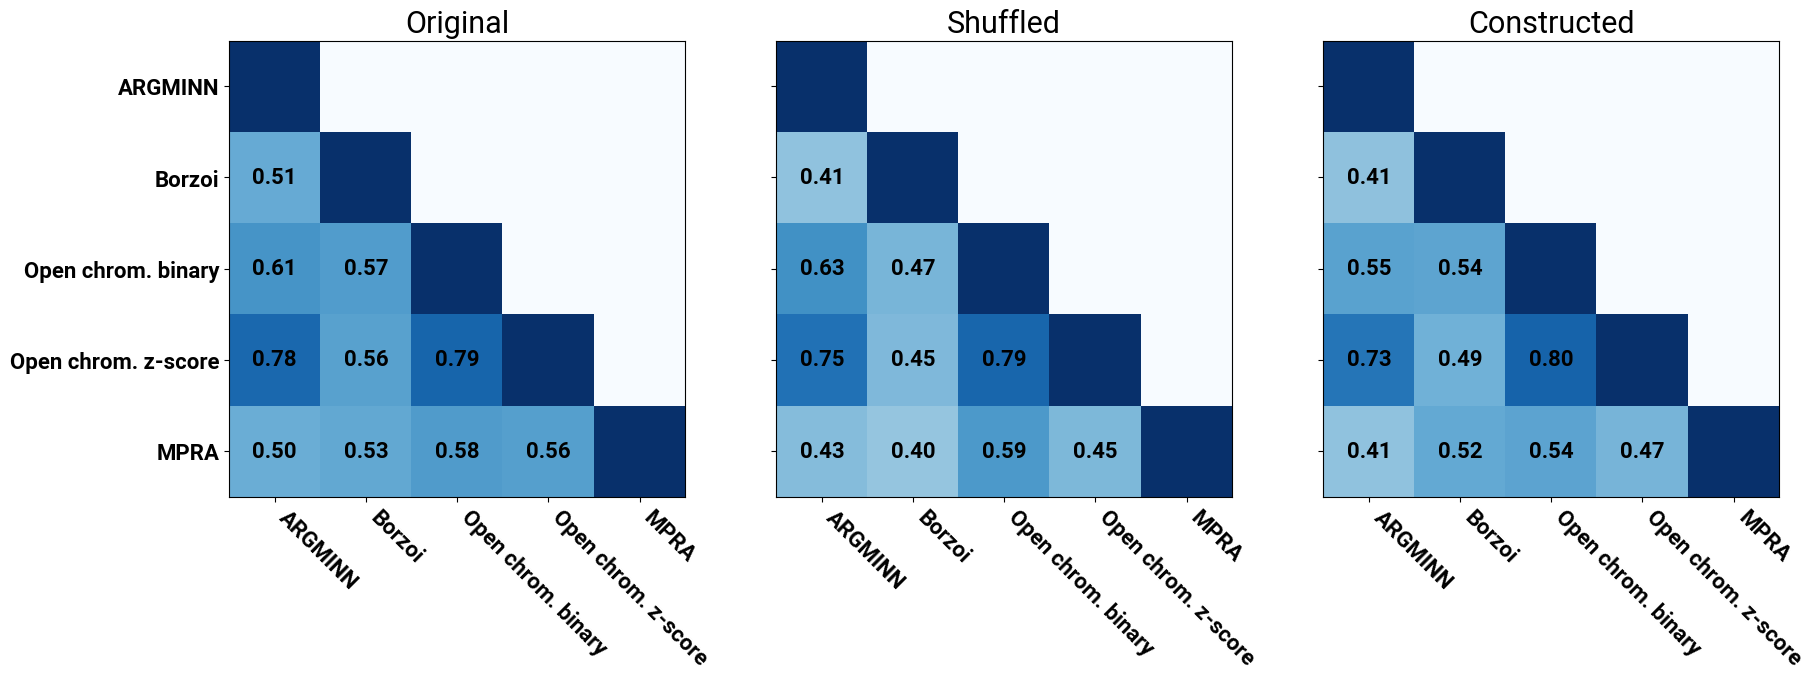

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

labels = ["ARGMINN", "Borzoi", "Open chrom. binary", "Open chrom. z-score", "MPRA"]

plot_correlation_heatmap(
    [orig_mechint_preds, orig_borzoi_preds, orig_ocb_preds, orig_ocz_preds, orig_mpra_preds],
    labels, ax[0]
)
ax[0].set_title("Original")

plot_correlation_heatmap(
    [shuf_mechint_preds, shuf_borzoi_preds, shuf_ocb_preds, shuf_ocz_preds, shuf_mpra_preds],
    labels, ax[1]
)
ax[1].set_title("Shuffled")
ax[1].set_yticklabels([])

plot_correlation_heatmap(
    [cons_mechint_preds, cons_borzoi_preds, cons_ocb_preds, cons_ocz_preds, cons_mpra_preds],
    labels, ax[2]
)
ax[2].set_title("Constructed")
ax[2].set_yticklabels([])
plt.show()

### Quantify "realness" of sequences

**Get embeddings**

In [10]:
# Import CAtlas model
artifact = grelu.resources.get_artifact(
    "model",
    "human-atac-catlas"
)

# Due to versioning issues, we need to update the checkpoint first
artifact_dir = artifact.download()
ckpt_file = os.path.join(artifact_dir, "model.ckpt")
new_ckpt_file = os.path.join(artifact_dir, "new_model.ckpt")
grelu.io.update_ckpt(ckpt_file, new_ckpt_file)

catlas_model = grelu.lightning.LightningModel.load_from_checkpoint(new_ckpt_file).to(DEVICE)

wandb: Currently logged in as: tseng-alex. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact model:latest, 1187.56MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3


Saving new checkpoint to /home/tsenga5/mechint_regnet/notebooks/artifacts/model:v5/new_model.ckpt


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


In [11]:
# Import sequences generated via other methods from the open-chromatin model
artifact = grelu.resources.get_artifact(
    "ending_seqs",
    "human-atac-encode-cell_lines"
)

artifact_dir = artifact.download()
oc_seqs_path = os.path.join(artifact_dir, "selected_sequences.csv")

oc_seqs_table = pd.read_csv(oc_seqs_path)

wandb:   1 of 1 files downloaded.  


In [12]:
# Filter OC sequences for cell-type of interest
oc_seqs_table = oc_seqs_table[oc_seqs_table["celltype"] == "HepG2"].reset_index(drop=True)

# Count design methods
methods, counts = np.unique(oc_seqs_table["method"], return_counts=True)
for m, c in zip(methods, counts):
    print("%d\t%s" % (c, m))

100	RegLM
2000	binary_subtract
75	ledidi_binary_absurd
2000	ledidi_binary_subtract
75	ledidi_zscore_absurd
2000	ledidi_zscore_subtract
2000	zscore_subtract


In [13]:
def get_catlas_embeddings(model, seqs):
    """
    Given a trained model and a list of ACGT sequences, runs predictions and returns
    a B x E array, where E is the embedding length
    """
    emb = model.embed_on_dataset(
        grelu.data.dataset.SeqDataset(list(seqs)),
        devices=DEVICE, num_workers=1
    )
    return np.reshape(emb, (emb.shape[0], -1))

In [14]:
# Compute embeddings
oc_seqs_embs = get_catlas_embeddings(catlas_model, list(oc_seqs_table["seq"]))
cons_embs = get_catlas_embeddings(catlas_model, list(cons_seqs))
orig_embs = get_catlas_embeddings(catlas_model, list(orig_seqs))
shuf_embs = get_catlas_embeddings(catlas_model, list(shuf_seqs))

/home/tsenga5/lib/grelu/src/grelu/lightning/__init__.py:844: embed_on_dataset currently only uses a single GPU: cuda


In [15]:
# Merge embeddings and labels into one array
embeddings = np.concatenate([oc_seqs_embs, cons_embs, orig_embs, shuf_embs])
emb_labels = np.concatenate([
    oc_seqs_table["method"],
    np.tile("ARGMINN", len(cons_embs)),
    np.tile("Original", len(orig_embs)),
    np.tile("Shuffled", len(shuf_embs))
])

In [16]:
# Perform PCA and UMAP
pca = sklearn.decomposition.PCA(n_components=25)
embeddings_pca = pca.fit_transform(embeddings)
umapper = umap.UMAP()
embeddings_pca_umap = umapper.fit_transform(embeddings_pca)

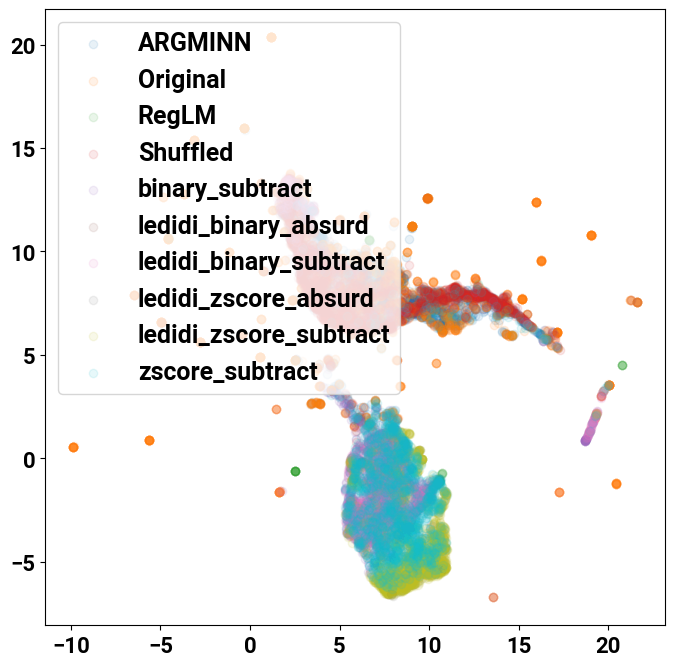

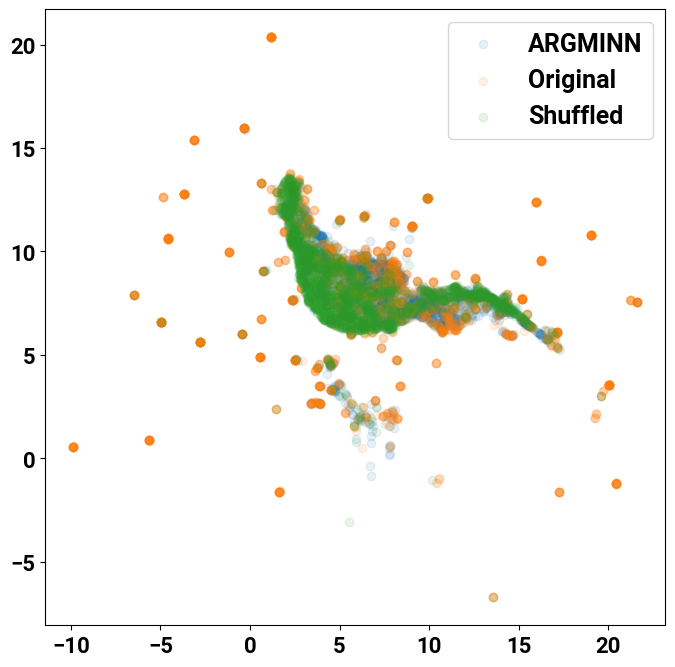

In [17]:
# Plot UMAP
fig, ax = plt.subplots(figsize=(8, 8))
for c in np.unique(emb_labels):
    mask = emb_labels == c
    ax.scatter(embeddings_pca_umap[mask, 0], embeddings_pca_umap[mask, 1], label=c, alpha=0.1)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
for c in ("ARGMINN", "Original", "Shuffled"):
    mask = emb_labels == c
    ax.scatter(embeddings_pca_umap[mask, 0], embeddings_pca_umap[mask, 1], label=c, alpha=0.1)
ax.legend()
plt.show()

### Select sequences

In [18]:
# Filter for high predictions
min_mechint_zscore = 1
min_borzoi_zscore = 1
min_ocb_zscore = 0
min_ocz_zscore = 0
min_mpra_zscore = 0

mechint_pass_mask = seq_table["cons_mechint_preds"] >= \
    np.mean(seq_table["cons_mechint_preds"]) + (min_mechint_zscore * np.std(seq_table["cons_mechint_preds"]))
borzoi_pass_mask = seq_table["cons_borzoi_preds"] >= \
    np.mean(seq_table["cons_borzoi_preds"]) + (min_borzoi_zscore * np.std(seq_table["cons_borzoi_preds"]))
ocb_pass_mask = seq_table["cons_ocb_preds"] >= \
    np.mean(seq_table["cons_ocb_preds"]) + (min_ocb_zscore * np.std(seq_table["cons_ocb_preds"]))
ocz_pass_mask = seq_table["cons_ocz_preds"] >= \
    np.mean(seq_table["cons_ocz_preds"]) + (min_ocz_zscore * np.std(seq_table["cons_ocz_preds"]))
mpra_pass_mask = seq_table["cons_mpra_preds"] >= \
    np.mean(seq_table["cons_mpra_preds"]) + (min_mpra_zscore * np.std(seq_table["cons_mpra_preds"]))

print("Num passing each: " + ", ".join([str(np.sum(m)) for m in (mechint_pass_mask, borzoi_pass_mask, ocb_pass_mask, ocz_pass_mask, mpra_pass_mask)]))

high_pred_seq_table = seq_table[
    mechint_pass_mask & borzoi_pass_mask & ocb_pass_mask & ocz_pass_mask & mpra_pass_mask
]

print("Num passing all: %d" % len(high_pred_seq_table))

for key, count in zip(*np.unique(high_pred_seq_table["motif_key"], return_counts=True)):
    print(count, "\t", key)

Num passing each: 483, 511, 964, 1272, 1094
Num passing all: 144
8 	 13-MA1134.1_FOS::JUNB|14-MA1683.1_FOXA3
4 	 13-MA1134.1_FOS::JUNB|16-MA0139.1_CTCF
2 	 13-MA1134.1_FOS::JUNB|2-MA1121.1_TEAD2
4 	 13-MA1134.1_FOS::JUNB|8-MA1607.1_Foxl2
1 	 14-MA1683.1_FOXA3
6 	 14-MA1683.1_FOXA3|13-MA1134.1_FOS::JUNB
11 	 14-MA1683.1_FOXA3|16-MA0139.1_CTCF
4 	 16-MA0139.1_CTCF
3 	 16-MA0139.1_CTCF|13-MA1134.1_FOS::JUNB
13 	 16-MA0139.1_CTCF|14-MA1683.1_FOXA3
29 	 16-MA0139.1_CTCF|16-MA0139.1_CTCF
11 	 16-MA0139.1_CTCF|2-MA1121.1_TEAD2
13 	 16-MA0139.1_CTCF|8-MA1607.1_Foxl2
1 	 17-MA0484.2_HNF4G
4 	 2-MA1121.1_TEAD2|13-MA1134.1_FOS::JUNB
15 	 2-MA1121.1_TEAD2|16-MA0139.1_CTCF
3 	 2-MA1121.1_TEAD2|8-MA1607.1_Foxl2
3 	 8-MA1607.1_Foxl2|13-MA1134.1_FOS::JUNB
1 	 8-MA1607.1_Foxl2|14-MA1683.1_FOXA3
7 	 8-MA1607.1_Foxl2|16-MA0139.1_CTCF
1 	 8-MA1607.1_Foxl2|2-MA1121.1_TEAD2


In [19]:
# Get embeddings
high_pred_cons_embs = get_catlas_embeddings(catlas_model, list(high_pred_seq_table["cons_seq"]))

/home/tsenga5/lib/grelu/src/grelu/lightning/__init__.py:844: embed_on_dataset currently only uses a single GPU: cuda


In [20]:
# Perform PCA and UMAP
pca = sklearn.decomposition.PCA(n_components=25)
high_pred_cons_embs_pca = pca.fit_transform(high_pred_cons_embs)
umapper = umap.UMAP()
high_pred_cons_embs_pca_umap = umapper.fit_transform(high_pred_cons_embs_pca)

In [21]:
# Select diverse examples using geosketching
sketch_inds = geosketch.gs(high_pred_cons_embs_pca_umap, 20, replace=False)

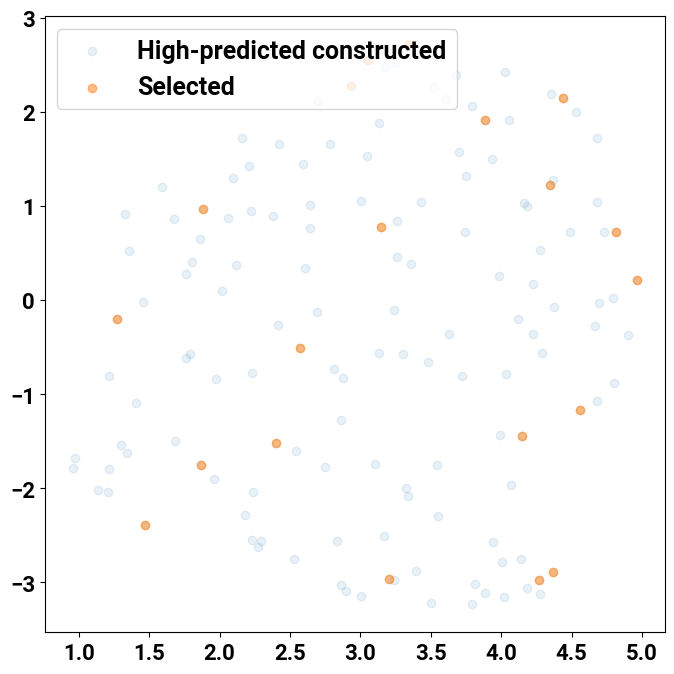

In [22]:
# Plot UMAP and selected sequences
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(high_pred_cons_embs_pca_umap[:, 0], high_pred_cons_embs_pca_umap[:, 1], label="High-predicted constructed", alpha=0.1)
ax.scatter(high_pred_cons_embs_pca_umap[sketch_inds, 0], high_pred_cons_embs_pca_umap[sketch_inds, 1], label="Selected", alpha=0.5)
ax.legend()
plt.show()

In [23]:
# Select out diverse sequences
selected_seqs = high_pred_seq_table.iloc[sketch_inds]
for key, count in zip(*np.unique(selected_seqs["motif_key"], return_counts=True)):
    print(count, "\t", key)

1 	 13-MA1134.1_FOS::JUNB|14-MA1683.1_FOXA3
1 	 13-MA1134.1_FOS::JUNB|2-MA1121.1_TEAD2
1 	 13-MA1134.1_FOS::JUNB|8-MA1607.1_Foxl2
1 	 14-MA1683.1_FOXA3|13-MA1134.1_FOS::JUNB
1 	 14-MA1683.1_FOXA3|16-MA0139.1_CTCF
1 	 16-MA0139.1_CTCF
2 	 16-MA0139.1_CTCF|13-MA1134.1_FOS::JUNB
4 	 16-MA0139.1_CTCF|16-MA0139.1_CTCF
3 	 16-MA0139.1_CTCF|2-MA1121.1_TEAD2
1 	 17-MA0484.2_HNF4G
2 	 2-MA1121.1_TEAD2|16-MA0139.1_CTCF
2 	 8-MA1607.1_Foxl2|13-MA1134.1_FOS::JUNB


In [24]:
selected_seqs.to_csv(
    os.path.join(out_path, "selected_seq_table.tsv"),
    sep="\t", index=False
)